In [1]:
import cv2 as cv
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

from PIL import Image


def draw_flipped_kpts(img_np, kpts_original, kpts_translated, title):
    for kpt in kpts_original:
        kpt.size = 50
        kpt.angle = math.pi / 2
    for kpt in kpts_translated:
        kpt.size = 25
        kpt.angle = 0
    kpts_all_cv = kpts_original + kpts_translated
    img_kpts = img_np.copy()
    cv.drawKeypoints(img_kpts, kpts_all_cv, img_kpts, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(9, 9))
    title = "{}: {} - translated of size 25, original of size 50".format(title, len(kpts_all_cv))
    plt.title(title)
    plt.imshow(img_kpts)
    plt.show()
    plt.close()


def mnn_generic(pts1, pts2, err_th):

    assert len(pts1.shape) == len(pts2.shape)

    pts1_r, pts2_r = pts1, pts2
    if len(pts1.shape) == 1:
        pts1_r, pts2_r = pts1[:, None].repeat(1, 2), pts2[:, None].repeat(1, 2)
        pts1_r[:, 1] = 0.0
        pts2_r[:, 1] = 0.0

    d_mat = torch.cdist(pts1_r, pts2_r)

    min0_values, min0_indices = torch.min(d_mat, dim=0)
    min1_values, min1_indices = torch.min(d_mat, dim=1)

    mask = min1_indices[min0_indices] == torch.arange(0, min0_indices.shape[0])
    mask2_boolean = mask & (min0_values < err_th)

    verify = True
    if verify:
        for i in range(min0_indices.shape[0]):
            if mask2_boolean[i]:
                assert min1_indices[min0_indices[i]] == i
                assert min0_values[i] < err_th

    mask1 = min0_indices[mask2_boolean]
    pts1_new = pts1[mask1]
    pts2_new = pts2[mask2_boolean]

    mask2 = mask2_boolean.nonzero()[:, 0]
    return pts1_new, pts2_new, mask1, mask2


def translate_experiment(file_path, detector, translation):

    img_np_o = np.array(Image.open(file_path))

    kpts_0_cv, _ = detector.detect(img_np_o, mask=None)
    kpts_0 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_0_cv])

    img_np_t = np.zeros_like(img_np_o)
    mt = -translation
    if translation[0] == 0:
        mt[0] = img_np_o.shape[0]
    if translation[1] == 0:
        mt[1] = img_np_o.shape[1]
    img_np_t[translation[0]:, translation[1]:] = img_np_o[:mt[0], :mt[1]]

    kpts_1_cv, _ = detector.detect(img_np_t, mask=None)
    kpts_1 = torch.tensor([[kp.pt[1], kp.pt[0]] for kp in kpts_1_cv]) - translation

    print("number of kpts: {}, {}".format(kpts_0.shape[0], kpts_1.shape[0]))

    # mnn
    kpts_0_new_1d, kpts_1_new_1d, mask_00, mask_10 = mnn_generic(kpts_0, kpts_1, err_th=2)
    print("number of filtered kpts: {}, {}".format(kpts_0_new_1d.shape[0], kpts_1_new_1d.shape[0]))

    distances = torch.linalg.norm(kpts_1_new_1d - kpts_0_new_1d)
    print("distances in 1D (where mnn was done) - min: {}, max: {}".format(distances.min(), distances.max()))

    def get_lists(i_l, torch_mask):
        m_l = torch_mask.tolist()
        matched_l, unmatched_l = [], []
        for index, item in enumerate(i_l):
            if index in m_l:
                matched_l.append(item)
            else:
                unmatched_l.append(item)
        return matched_l, unmatched_l

    # visualize the matched and umatched keypoints
    kpts_0_cv_matched, kpts_0_cv_unmatched = get_lists(kpts_0_cv, mask_00)
    kpts_1_cv_matched, kpts_1_cv_unmatched = get_lists(kpts_1_cv, mask_10)
    print("Matched keypoints: {}".format(len(kpts_0_cv_matched) + len(kpts_1_cv_matched)))
    print("Unmatched keypoints: {}".format(len(kpts_0_cv_unmatched) + len(kpts_1_cv_unmatched)))
    draw_flipped_kpts(img_np_o, kpts_0_cv_matched, kpts_1_cv_matched, "matched keypoints")
    draw_flipped_kpts(img_np_o, kpts_0_cv_unmatched, kpts_1_cv_unmatched, "unmatched keypoints")

    mean = (kpts_1_new_1d - kpts_0_new_1d).mean()
    var = (kpts_1_new_1d - kpts_0_new_1d).var()
    print("mean: {}, variance: {}".format(mean, var))


def translate_experiment_loop(detector, img_to_show):
    for translation in torch.tensor([[4, 4], [4, 0], [0, 4]]):
        img_dir = "demo_imgs"
        files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
        for file_path in files:
            translate_experiment(file_path, detector, translation)


/Users/vaclav/miniconda3/envs/kpt_loc/lib/python3.10/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


number of kpts: 700, 699
number of filtered kpts: 604, 604
distances in 1D (where mnn was done) - min: 17.029386520385742, max: 17.029386520385742
Matched keypoints: 1208
Unmatched keypoints: 191


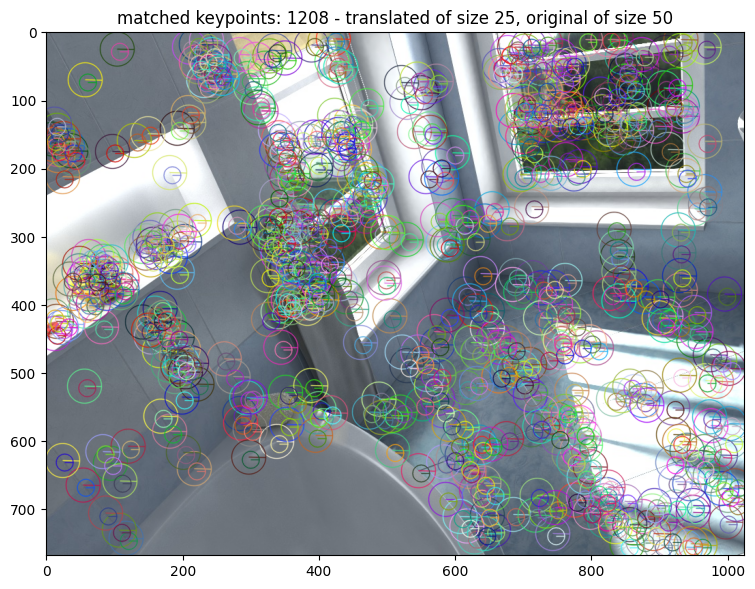

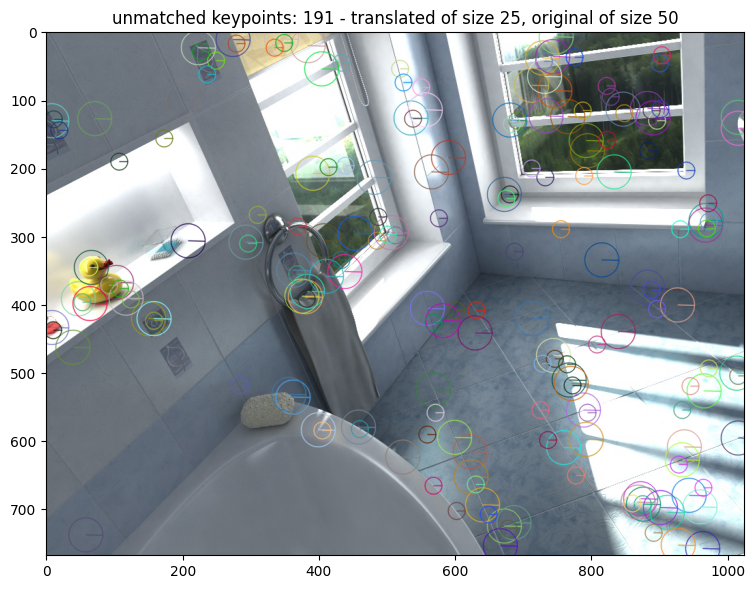

mean: -0.0066225165501236916, variance: 0.24022123217582703
number of kpts: 395, 366
number of filtered kpts: 330, 330
distances in 1D (where mnn was done) - min: 11.401754379272461, max: 11.401754379272461
Matched keypoints: 660
Unmatched keypoints: 101


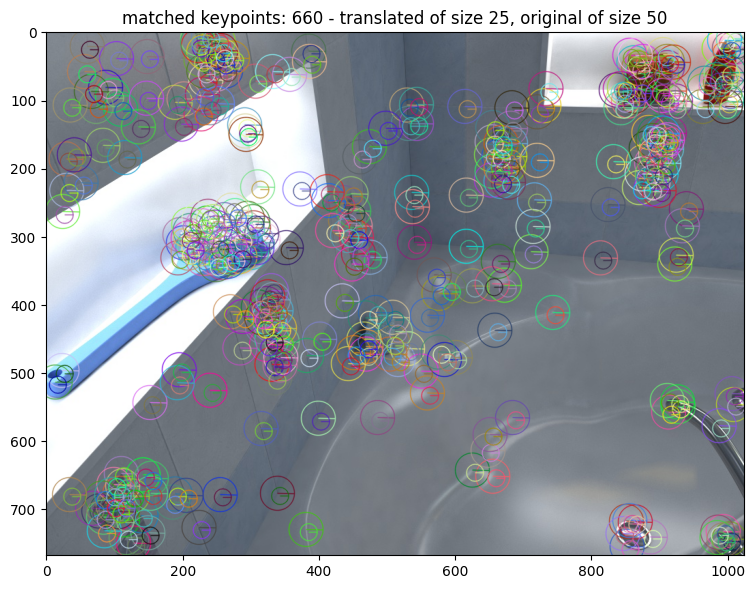

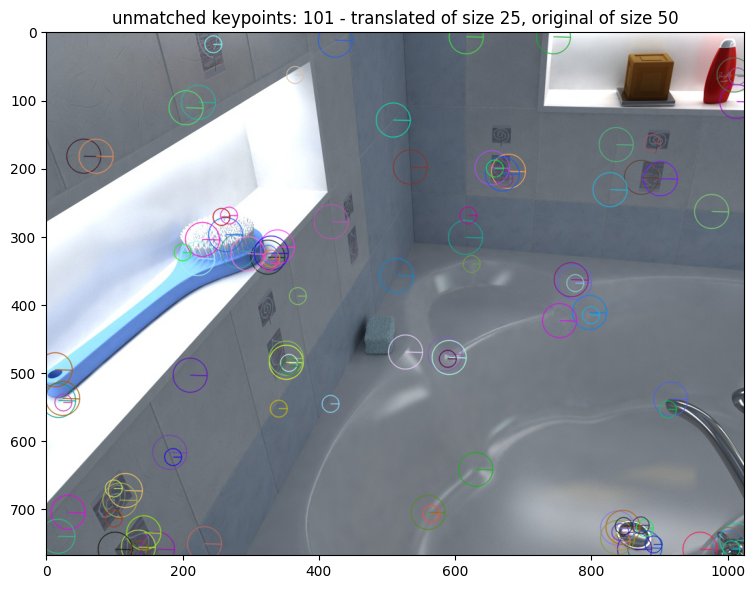

mean: -0.05454545468091965, variance: 0.19428886473178864
number of kpts: 700, 699
number of filtered kpts: 613, 613
distances in 1D (where mnn was done) - min: 15.36229133605957, max: 15.36229133605957
Matched keypoints: 1226
Unmatched keypoints: 173


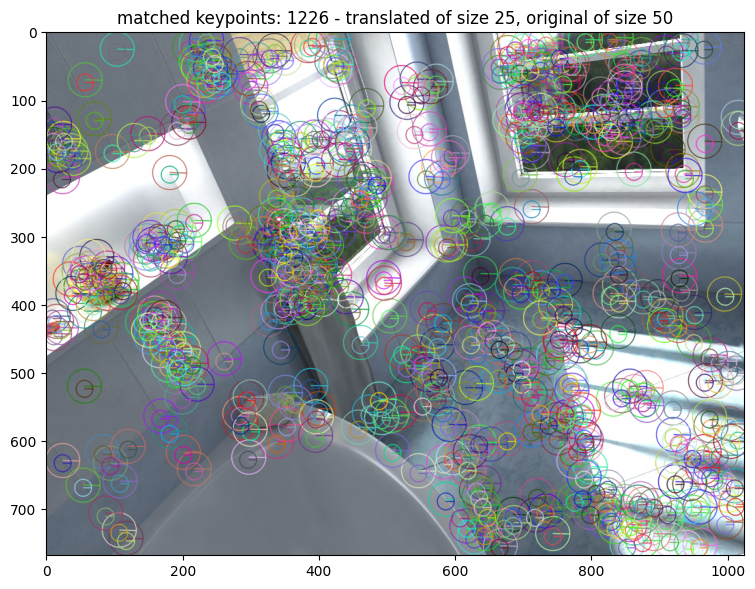

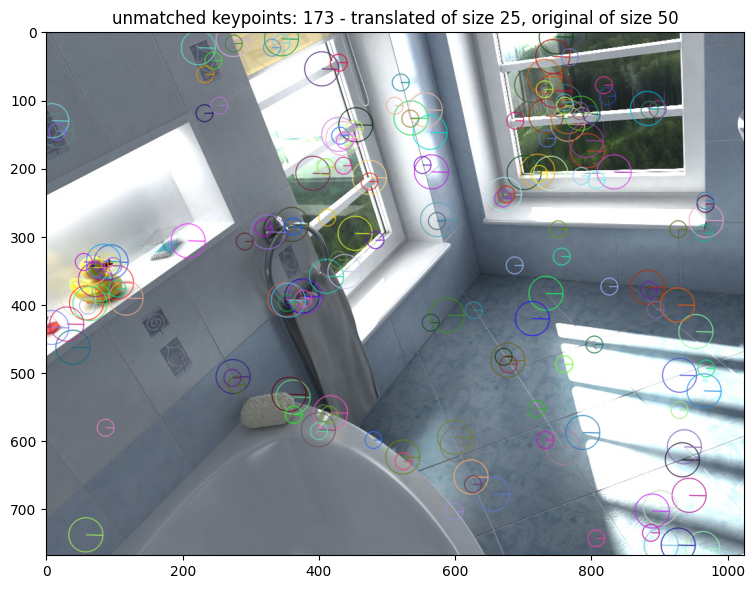

mean: -0.02446982078254223, variance: 0.19205379486083984
number of kpts: 395, 387
number of filtered kpts: 345, 345
distances in 1D (where mnn was done) - min: 11.747340202331543, max: 11.747340202331543
Matched keypoints: 690
Unmatched keypoints: 92


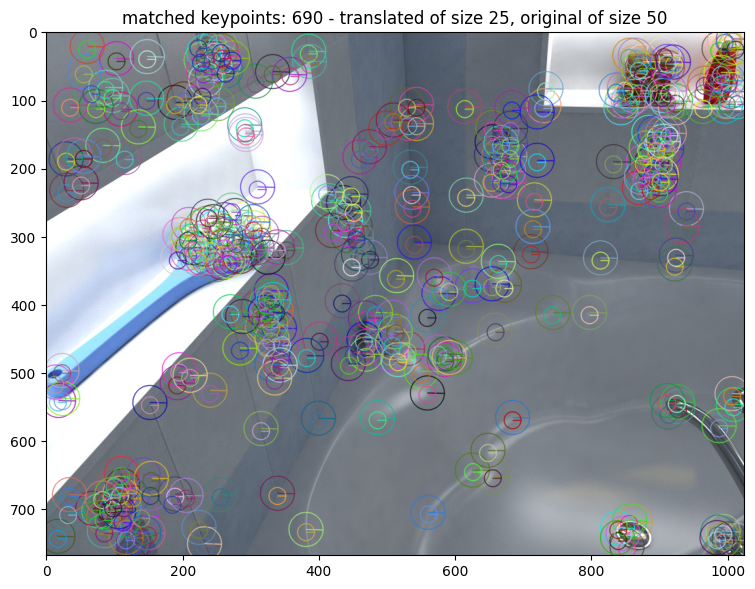

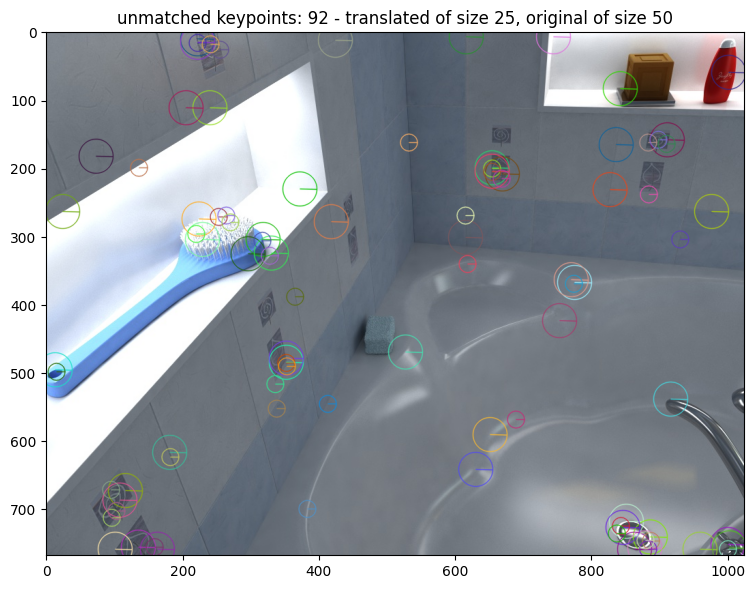

mean: -0.017391303554177284, variance: 0.19998738169670105
number of kpts: 700, 693
number of filtered kpts: 624, 624
distances in 1D (where mnn was done) - min: 16.76305389404297, max: 16.76305389404297
Matched keypoints: 1248
Unmatched keypoints: 145


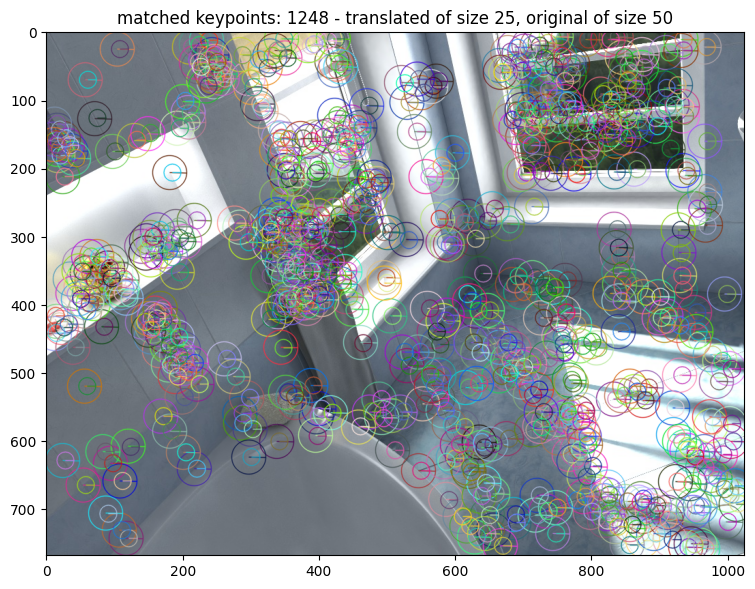

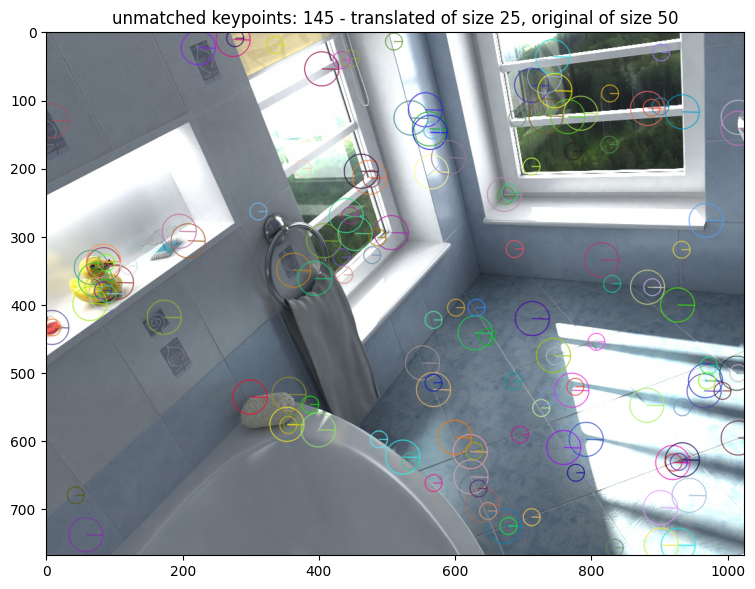

mean: -0.005608974490314722, variance: 0.2253093272447586
number of kpts: 395, 388
number of filtered kpts: 343, 343
distances in 1D (where mnn was done) - min: 11.045360565185547, max: 11.045360565185547
Matched keypoints: 686
Unmatched keypoints: 97


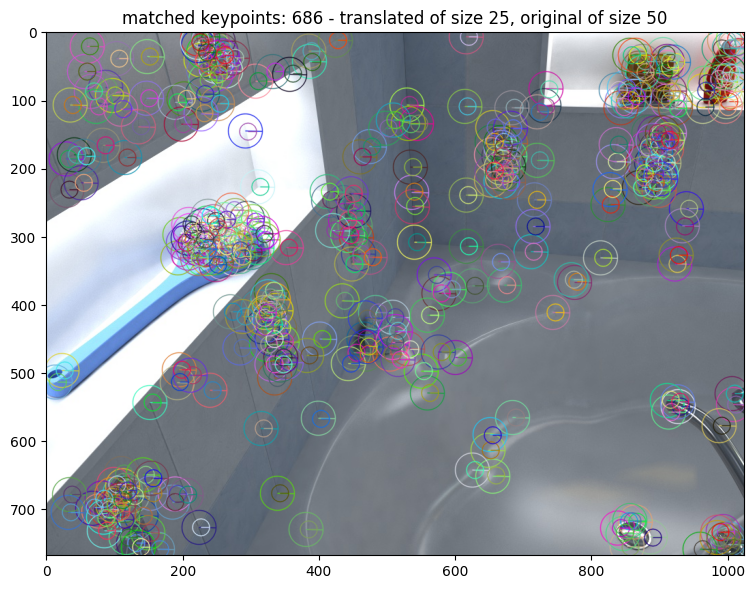

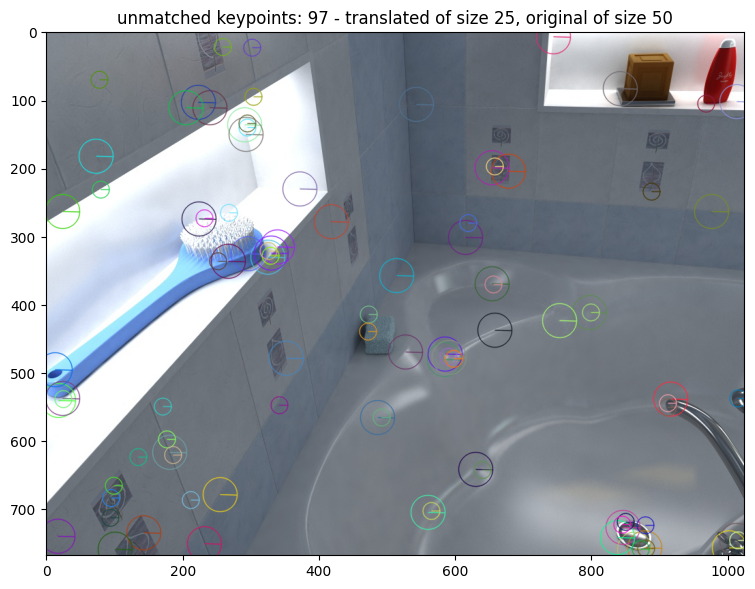

mean: -0.011661808006465435, variance: 0.17796599864959717


In [2]:
from superpoint_local import SuperPointDetector
detector = SuperPointDetector()
translate_experiment_loop(detector, img_to_show=2)
